# Image data
The goal of this notebook is to detail how to interact with, and compute statistics on the images associated to the set of ads provided for the CP1 during the MEMEX Winter QPR 2017.

### Data to download
Data posted on HDFS, see Wiki page.

- Training images
- Training images info
- Test images
- Test images info

Plus the data available on the Wiki

### Info files
1. adjusted_images.json
2. image_url_sha1.csv
3. faces.jl
4. images_faces_stats.jl

In [1]:
import os
import csv
import json

In [2]:
# set some parameters
data_dir = "../data"
prefix = "test"
if prefix=="train":
    input_file = "train_adjusted.json"
else:
    input_file = "test_adjusted_unlabelled.json"

In [3]:
images_dir = os.path.join(data_dir,prefix+"_images")
url_sha1_file = os.path.join(data_dir,prefix+"_image_url_sha1.csv")
faces_file = os.path.join(data_dir,prefix+"_faces.jl")
stats_file = os.path.join(data_dir,prefix+"_images_faces_stats.jl")
images_file = os.path.join(data_dir,prefix+"_adjusted_images.json")

In [4]:
# parse faces_file
def parse_faces(faces_file):
    faces_dict = {}
    with open(faces_file, "rt") as faces:
        for line in faces:
            one_face_dict = json.loads(line)
            img_sha1 = one_face_dict.keys()[0]
            nb_faces = len(one_face_dict[img_sha1].keys())
            #print nb_faces
            faces_dict[img_sha1] = dict()
            faces_dict[img_sha1]['count'] = nb_faces
            faces_dict[img_sha1]['detections'] = one_face_dict[img_sha1]
    return faces_dict

In [5]:
faces_dict = parse_faces(faces_file)

In [6]:
print len(faces_dict)
i = 3
print faces_dict.keys()[i], faces_dict[faces_dict.keys()[i]]

20401
3140d44a1e4f2a84f10265fb03d0472c89681ed0 {'count': 1, 'detections': {u'3140d44a1e4f2a84f10265fb03d0472c89681ed0_160-31-227-122': {u'score': u'0.997924685478', u'bbox': u'160.391361728,31.2674056292,227.213230789,122.488013085'}}}


In [7]:
# parse images_file
def parse_images_file(images_file):
    ads_images_dict = {}
    with open(images_file, "rt") as images:
        for line in images:
            one_image_dict = json.loads(line)
            ad_id_list = one_image_dict['obj_parent']
            img_url = one_image_dict['obj_stored_url']
            if type(ad_id_list) is not list:
                ad_id_list = [ad_id_list]
            for ad_id in ad_id_list:
                if ad_id not in ads_images_dict:
                    ads_images_dict[ad_id] = [img_url]
                else:
                    ads_images_dict[ad_id].append(img_url)
    return ads_images_dict

In [8]:
ads_images_dict = parse_images_file(images_file)

In [9]:
print len(ads_images_dict)
print ads_images_dict.keys()[0],ads_images_dict[ads_images_dict.keys()[0]]

21984
28DE96FEE11CB9182D318FC40599E579C69E99D25DB233F64C98F13081DBC018 [u'https://s3.amazonaws.com/roxyimages/e6285c42db6f7332f0e842a4d10d2c1bcaca8d58.jpg', u'https://s3.amazonaws.com/roxyimages/238cb337defb4ae99e2e357d585a0053e5072fcc.jpg', u'https://s3.amazonaws.com/roxyimages/439d654bc365f36daccff602849ba7bb3a608836.jpg', u'https://s3.amazonaws.com/roxyimages/420957839e1eb4a41ec19c283130f633006cbf56.jpg', u'https://s3.amazonaws.com/roxyimages/c86cea7543c8f855dd77c0037e146aef1fd81d1a.jpg', u'https://s3.amazonaws.com/roxyimages/32ebde5b3cabb7773346d41b333c04e0d89ff4e3.jpg', u'https://s3.amazonaws.com/roxyimages/6fea3fe79e0e2eef18a09f0daf9c998e796ce7cd.jpg', u'https://s3.amazonaws.com/roxyimages/5163ef2e476107b4c7a31d22021a6e200bc8c03e.jpg', u'https://s3.amazonaws.com/roxyimages/c9af9f955efce2533ee0df843eaba666aff7cb28.jpg', u'https://s3.amazonaws.com/roxyimages/83845b26e5a25e00dd7c5c7c8894cdddc2493285.jpg']


In [10]:
# parse image_url_sha1_file
def parse_url_sha1_file(url_sha1_file):
    url_sha1_dict = {}
    with open(url_sha1_file,"rt") as img_url_sha1:
        for line in img_url_sha1:
            url, sha1 = line.split(',')
            url_sha1_dict[url] = sha1
    return url_sha1_dict

In [11]:
 url_sha1_dict = parse_url_sha1_file(url_sha1_file)

In [12]:
print len(url_sha1_dict)
print url_sha1_dict.keys()[0],url_sha1_dict[url_sha1_dict.keys()[0]]

54569
https://s3.amazonaws.com/memex-images/full/85d9a4e5f4927f22218f79f496a14757ee8b3413.jpg f912b73662a9a50e42cb5d7726beea69c4ba0b56



## Analyze image stats

In [137]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [136]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Images distribution

In [145]:
def get_ad_images(ad_id, ads_images_dict, url_sha1_dict, verbose=False):
    images_url_list = ads_images_dict[ad_id]
    images_sha1s = []
    for image_url in images_url_list:
        if image_url is None or not image_url:
            continue
        try:
            images_sha1s.append(url_sha1_dict[image_url.strip()].strip())
        except:
            if verbose:
                print 'Cannot find sha1 for: {}.'.format(image_url)
    return images_sha1s

In [146]:
# Analyze distribution of images in ads_images_dict
images_count = []
for ad_id in ads_images_dict:
    images_count.append(len(get_ad_images(ad_id, ads_images_dict, url_sha1_dict)))

In [151]:
def print_stats(np_img_count):
    print np.min(np_img_count), np.mean(np_img_count), np.max(np_img_count)
    # Normed histogram seems to be broken, 
    # using weights as suggested in http://stackoverflow.com/questions/5498008/pylab-histdata-normed-1-normalization-seems-to-work-incorrect
    weights = np.ones_like(np_img_count)/float(len(np_img_count))
    res = plt.hist(np_img_count, bins=100, weights=weights)
    print np.sum(res[0])
    # Create the formatter using the function to_percent. This multiplies all the
    # default labels by 100, making them all percentages
    formatter = FuncFormatter(to_percent)

    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()

0 8.40438500728 420
1.0


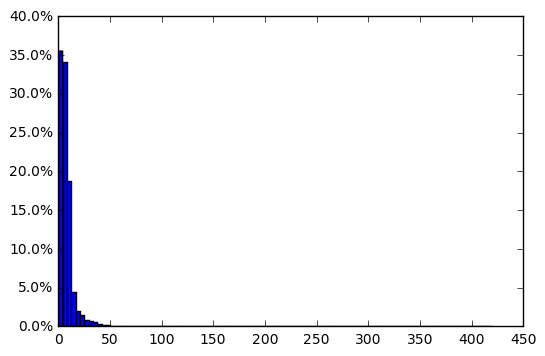

In [152]:
print_stats(np.asarray(images_count))

### Faces distribution

In [149]:
def get_faces_images(images_sha1s, faces_dict):
    faces_out = {}
    for sha1 in images_sha1s:
        img_notfound = False
        try:
            tmp_faces = faces_dict[sha1]
        except:
            img_notfound = True
        if img_notfound or tmp_faces['count']==0:
            faces_out[sha1] = []
            continue
        bboxes = []
        for face in tmp_faces['detections']:
            bbox = [float(x) for x in tmp_faces['detections'][face]['bbox'].split(',')]
            bbox.append(float(tmp_faces['detections'][face]['score']))
            bboxes.append(bbox)
        #print bboxes
        faces_out[sha1] = bboxes
    return faces_out

In [180]:
def show_faces(faces, images_dir):
    from matplotlib.pyplot import imshow
    from IPython.display import display
    import numpy as np
    %matplotlib inline

    imgs = []
    for face in faces:
        if faces[face]:
            img = open_image(face, images_dir)
            draw_face_bbox(img, faces[face])
            imgs.append(img)
    if not imgs:
        print 'No face images'
    display(*imgs)

In [150]:
# get all faces ads from each ad
faces_in_images_percent = []
for ad_id in ads_images_dict:
    images_sha1s = get_ad_images(ad_id, ads_images_dict, url_sha1_dict)
    faces_images = get_faces_images(images_sha1s, faces_dict)
    if len(faces_images)==0:
        continue
    nb_faces = 0
    for face in faces_images:
        if faces_images[face]:
            nb_faces += 1
            faces_in_images_percent.append(float(nb_faces)/len(faces_images))

0.0 0.449694108153 1.0
1.0


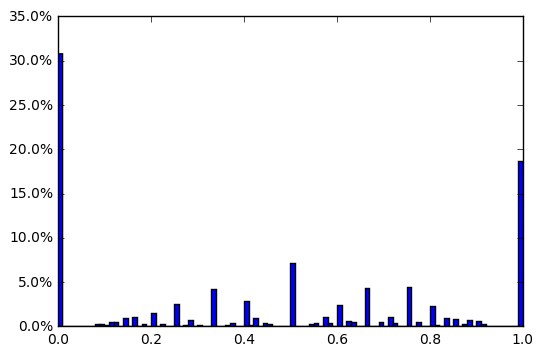

In [154]:
np_faces_in_images_percent = np.asarray(faces_in_images_percent)
print_stats(np_faces_in_images_percent)

In [163]:
no_faces = np.where(np_faces_in_images_percent==0.0)
print no_faces[0].shape
print np_faces_in_images_percent.shape
percent_noface = float(no_faces[0].shape[0])/np_faces_in_images_percent.shape[0]
print 1-percent_noface

(6583,)
(21388,)
0.692210585375


In [187]:
# get all faces scores from each ad
faces_scores = []
all_faces = []
for ad_id in ads_images_dict:
    images_sha1s = get_ad_images(ad_id, ads_images_dict, url_sha1_dict)
    faces_images = get_faces_images(images_sha1s, faces_dict)
    if len(faces_images)==0:
        continue
    nb_faces = 0
    for face in faces_images:
        if faces_images[face]:
            for one_face in faces_images[face]:
                all_faces.append([face, one_face])
                faces_scores.append(float(one_face[4]))

0.700168728828 0.970464453852 1.0
1.0


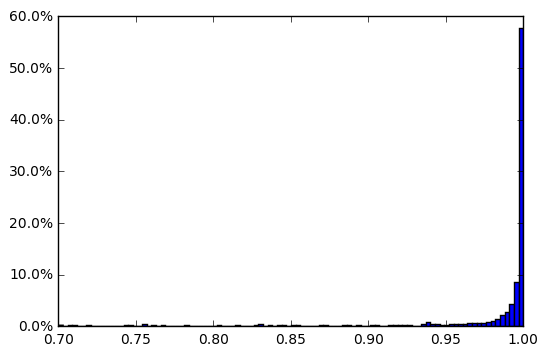

In [188]:
np_faces_scores = np.asarray(faces_scores)
print_stats(faces_scores)

In [189]:
low_scores_faces = np.where(np_faces_scores<0.90)[0]
print float(len(low_scores_faces))/len(np_faces_scores)
very_low_scores_faces = np.where(np_faces_scores<0.80)[0]
print float(len(very_low_scores_faces))/len(np_faces_scores)
#all_faces
print len(np_faces_scores)

0.112372655097
0.0514016721703
71165


In [ ]:
nb_faces_to_show = 10
np.random.shuffle(very_low_scores_faces)
faces_to_show = [all_faces[x] for x in very_low_scores_faces[:nb_faces_to_show]]
print faces_to_show
for face_id, face in faces_to_show:
    print face_id, face
    face_dict = {}
    face_dict[face_id] = [face]
    show_faces(face_dict, images_dir)

## Show images and faces of one ad

In [57]:
def get_fnt(img, txt):
    from PIL import ImageFont
    # portion of image width you want text width to be
    img_fraction = 0.20
    fontsize = 2
    font = ImageFont.truetype("arial.ttf", fontsize)
    while font.getsize(txt)[0] < img_fraction*img.size[0]:
        # iterate until the text size is just larger than the criteria
        fontsize += 1
        font = ImageFont.truetype("arial.ttf", fontsize)
    return font, font.getsize(txt)[0]

In [63]:
def draw_face_bbox(img, bboxes, width=4):
    from PIL import ImageDraw
    import numpy as np
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        for i in range(width):
            rect_start = (int(np.round(bbox[0] + width/2 - i)), int(np.round(bbox[1] + width/2 - i)))
            rect_end = (int(np.round(bbox[2] - width/2 + i)), int(np.round(bbox[3] - width/2 + i)))
            draw.rectangle((rect_start, rect_end), outline=(0, 255, 0))
        # print score?
        if len(bbox)==5:
            score = str(bbox[4])
            fnt, text_size = get_fnt(img, score[:5])
            draw.text((np.round((bbox[0]+bbox[2])/2-text_size/2),np.round(bbox[1])), score[:5], font=fnt, fill=(255,255,255,64))

In [64]:
def open_image(sha1, images_dir):
    from PIL import Image
    img = Image.open(os.path.join(images_dir, sha1[:3], sha1))
    return img

In [240]:
#face images of ad '84FC37A4E38F7DE2B9FCAAB902332ED60A344B8DF90893A5A8BE3FC1139FCD5A' are blurred but detected
# image '20893a926fbf50d1a5994f70ec64dbf33dd67e2a' highly pixelated
# male strippers '20E4597A6DA11BC07BB7578FFFCE07027F885AF02265FD663C0911D2699E0A79'

In [ ]:
all_ads_id = range(len(ads_images_dict.keys()))
import numpy as np
np.random.shuffle(all_ads_id)
ad_id = ads_images_dict.keys()[all_ads_id[0]]
print ad_id
images_sha1s = get_ad_images(ad_id, ads_images_dict, url_sha1_dict)
print images_sha1s
faces = get_faces_images(images_sha1s, faces_dict)
print faces
show_faces(faces, images_dir)